Basic UNET 64x64 testing

In [ ]:
%tensorflow_version 1.4.1

import tensorflow
print(tensorflow.__version__)

import os
from google.colab import drive
drive.mount('/content/gdrive')

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.4.1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import keras
np.random.seed(123)  # for reproducibility
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Layer, Input, Lambda 
from keras.layers import Multiply, Add, BatchNormalization, Reshape
from keras.layers import UpSampling2D, Convolution2D, LeakyReLU, Flatten, ReLU

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from keras.datasets import mnist
from keras import backend as K
from scipy.stats import norm

import matplotlib.image as mpimg
import sys

from tqdm import tqdm_notebook
from IPython import display
%matplotlib inline

from keras import initializers
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D

Using TensorFlow backend.


In [ ]:
orig_dir = '/content/gdrive/My Drive/NEUTROPHIL/Train/64/64'
print('total images:', len(os.listdir(orig_dir)))
temp = os.listdir(orig_dir)

total images: 4002


In [ ]:
valid_dir = '/content/gdrive/My Drive/NEUTROPHIL/Valid/64/64'
print('total images:', len(os.listdir(valid_dir)))
temp_valid = os.listdir(orig_dir)

total images: 996


In [ ]:
test_dir = '/content/gdrive/My Drive/NEUTROPHIL/Test/64/64'
print('total images:', len(os.listdir(test_dir)))
test_valid = os.listdir(test_dir)

total images: 1248


In [ ]:
import tensorflow
from keras.preprocessing.image import ImageDataGenerator

# Rescale
train_datagen = ImageDataGenerator(rescale=1./255)
train_dir_in = '/content/gdrive/My Drive/NEUTROPHIL/Train/64'

image_generator = train_datagen.flow_from_directory(
        train_dir_in,  # Source
        target_size=(64, 64),  # All images will be resized to 32x32
        batch_size= 32,
        color_mode="rgb",
        class_mode=None,
        shuffle=False
        )


Found 4002 images belonging to 1 classes.


In [ ]:
# Rescale
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_dir_in = '/content/gdrive/My Drive/NEUTROPHIL/Valid/64'

image_generator_valid = valid_datagen.flow_from_directory(
        valid_dir_in,  # Source
        target_size=(64, 64),  # All images will be resized to 32x32
        batch_size= 32,
        color_mode="rgb",
        class_mode=None,
        shuffle=False
        )

Found 996 images belonging to 1 classes.


In [ ]:
# Rescale
test_datagen = ImageDataGenerator(rescale=1./255)
test_dir_in = '/content/gdrive/My Drive/NEUTROPHIL/Test/64'

image_generator_test = test_datagen.flow_from_directory(
        test_dir_in,  # Source
        target_size=(64, 64),  # All images will be resized to 32x32
        batch_size= 32,
        color_mode="rgb",
        class_mode=None,
        shuffle=False
        )

Found 1248 images belonging to 1 classes.


In [ ]:
import keras
from keras.datasets import cifar10, cifar100
from keras.layers import Lambda, Input
from keras.models import Model
import tensorflow as ktf
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random

batchsizeX = 32
datalengthx = 4002
batchsizey =32
datalengthy = 1248

class DataLoader():
  def __init__(self, dataset_name, img_res=(64, 64)):
    self.img_res = img_res
    
  def get_dataset_shape(self, is_training=True, is_testing=False):
    if is_training:
      return (4002,64,64,3)
    elif is_testing:
      return (1248,64,64,3)
    else:
      return (996,64,64,3)
    
  def get_num_batches(self, batch_size, is_training=True, is_testing=False):
    if is_training:
      return 126
    elif is_testing:
      return 37
    else:
      return 32
    
  def set_image_transformations(self, fourier_convert):
    
    self.fourier_convert = fourier_convert
  
  def load_batch(self, batch_size=1, is_training=True,is_testing=False, borrow_magnitude = 0):  
    if is_training:    
      num_batches = 123
    elif is_testing:
      num_batches = 37
    else:
      num_batches = 30 
    for idx_batch in range(num_batches):    
      if is_training:
        batch = image_generator[idx_batch]
      elif is_testing:
        batch = image_generator_test[idx_batch]
      else:
        batch = image_generator_valid[idx_batch]
      batch = batch.astype('float32')
      batch = np.reshape(batch, (batch_size, self.img_res[0], self.img_res[1], 3))       
      # Convert to mask
      batch_ft = self.fourier_convert(batch, borrow_magnitude)
      yield [batch, batch_ft]

  def get_random_batch(self, batch_size=1, is_training=True,is_testing=False, borrow_magnitude = 0):
    
    if is_training:
      idx = random.randint(0, 123)
      batch = image_generator[idx]
      batch = batch[0:batch_size]
    if is_testing:
      idx = random.randint(0, 38)
      batch = image_generator_test[idx]
      batch = batch[0:batch_size]
    else:
      idx = random.randint(0, 30)
      batch = image_generator_valid[idx]
      batch = batch[0:batch_size]

    batch = np.reshape(batch, (batch_size, self.img_res[0], self.img_res[1], 3))
        
    # mask conversion
    batch_ft = self.fourier_convert(batch, borrow_magnitude)
      
    return [batch, batch_ft]


In [ ]:
dataset_loader = DataLoader(dataset_name = 'MYDATA')
training_shape = dataset_loader.get_dataset_shape()
test_shape = dataset_loader.get_dataset_shape(is_training=False,is_testing=True)
valid_shape = dataset_loader.get_dataset_shape(is_training=False,is_testing=False)
print('Shape of Training Images: {}'.format(training_shape))
print('Shape of Test Images: {}'.format(test_shape))
print('Shape of Valid Images: {}'.format(valid_shape))

Shape of Training Images: (4002, 64, 64, 3)
Shape of Test Images: (1248, 64, 64, 3)
Shape of Valid Images: (996, 64, 64, 3)


In [ ]:
import numpy as np
from numpy import isneginf
from scipy.stats import iqr 

def compute_mag_phase(toBeTransfromed):
    dft = np.fft.fft2(toBeTransfromed)
    dft_shift = np.fft.fftshift(dft)
    mag = np.abs(dft_shift)
    ang = np.angle(dft_shift)
    return mag, ang

def reconstruct(mag,ang):
    combined = np.multiply(mag, np.exp(1j*ang))
    fftx = np.fft.ifftshift(combined)
    ffty = np.fft.ifft2(fftx)
    imgCombined = np.abs(ffty)
    return imgCombined

In [ ]:
borrow_magnitude_0 = image_generator[0][0]
mag_borrow, ang = compute_mag_phase(borrow_magnitude_0)
del ang

In [ ]:
def transformx(img, mag_borrow):
    mag,ang = compute_mag_phase(img)
    del mag
    im = reconstruct(mag_borrow,ang)
    return im 


def reconstructAll(imgArray, mag_borrow):
    batch = np.zeros(imgArray.shape)
    for i in range(0,imgArray.shape[0]):
      imgx = imgArray[i,:,:,:]
      batch[i,:,:,:] = transformx(imgArray[i,:,:,:], mag_borrow)
    return batch

In [ ]:
dataset_loader.set_image_transformations(reconstructAll)

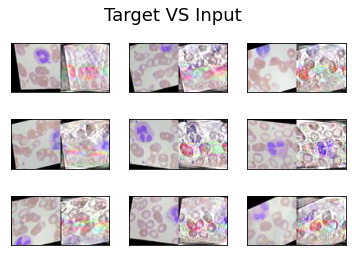

In [ ]:
random_batch = dataset_loader.get_random_batch(batch_size=9, borrow_magnitude= mag_borrow)

# Repeat last dimension for visualization
tmp = np.repeat(random_batch[1], 1, axis=3)

N=3
start_val = 0
fig, axes = plt.subplots(N,N)
plt.suptitle('Target VS Input', fontsize=18)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    im = np.concatenate((random_batch[0][idx], tmp[idx]), 1)
    axes[row,col].imshow(np.clip(im, 0, 1))
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

Test

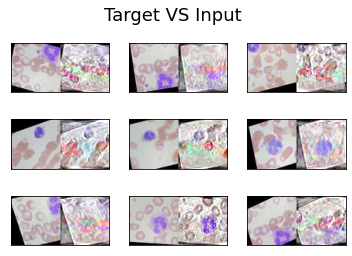

In [ ]:
random_batch = dataset_loader.get_random_batch(batch_size=9, is_training = False, is_testing=True ,borrow_magnitude= mag_borrow)

# Repeat last dimension for visualization
tmp = np.repeat(random_batch[1], 1, axis=3)

N=3
start_val = 0
fig, axes = plt.subplots(N,N)
plt.suptitle('Target VS Input', fontsize=18)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    im = np.concatenate((random_batch[0][idx], tmp[idx]), 1)
    axes[row,col].imshow(np.clip(im, 0, 1))
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

Valid

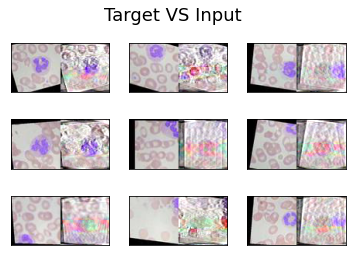

In [ ]:
random_batch = dataset_loader.get_random_batch(batch_size=9, is_training = False, is_testing=False ,borrow_magnitude= mag_borrow)

# Repeat last dimension for visualization
tmp = np.repeat(random_batch[1], 1, axis=3)

N=3
start_val = 0
fig, axes = plt.subplots(N,N)
plt.suptitle('Target VS Input', fontsize=18)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    im = np.concatenate((random_batch[0][idx], tmp[idx]), 1)
    axes[row,col].imshow(np.clip(im, 0, 1))
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [ ]:
from keras.layers import Dropout, merge, concatenate, UpSampling2D, MaxPooling2D
from keras.layers import Conv2D, Dense, Reshape, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2D, Input, Dense, Reshape, Flatten
from keras.optimizers import Adam

def build_UNET(im_shape):  
  img_B = Input(shape=(im_shape[0], im_shape[1], 3))

    #convolution and pool (downsample) #1
  c_0 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(img_B)
  p_0 = MaxPooling2D(pool_size=(2, 2))(c_0)
  #convolution and pool (downsample) #2
  c_1 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(p_0)
  p_1 = MaxPooling2D(pool_size=(2, 2))(c_1)
  #convolution and pool (downsample) #3
  c_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(p_1)
  p_2 = MaxPooling2D(pool_size=(2, 2))(c_2)
  #convolution and pool (downsample), dropout #4
  c_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(p_2)
  d_0 = Dropout(0.5)(c_3)
  p_3 = MaxPooling2D(pool_size=(2, 2))(d_0)
  #convolution and  dropout #5
  c_4 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(p_3)
  d_1 = Dropout(0.5)(c_4)

  # upsample
  u_0 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(d_1))
  m_0 = concatenate([d_0,u_0], axis = 3)
  uc_0 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m_0)

  u_1 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(uc_0))
  m_1 = concatenate([c_2,u_1], axis = 3)
  uc_1 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m_1)

  u_2 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(uc_1))
  m_2 = concatenate([c_1,u_2], axis = 3)
  uc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m_2)

  u_3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(uc_2))
  m_3 = concatenate([c_0,u_3], axis = 3)
  uc_3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m_3)
  out = Conv2D(3, 3,  padding = 'same')(uc_3)

  model = Model(inputs = img_B, outputs = out, name='generator')
  
  return model

In [ ]:
im_shape = (64, 64)
UNET = build_UNET(im_shape)

image_in = Input(shape=(im_shape[0], im_shape[1], 3))

image_out = UNET(image_in)

UNET_MODEL = Model(inputs=image_in, outputs=image_out)
UNET_MODEL.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mae'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
def showColoredIms(A, B, C):
  
  plt.subplot(131)
  plt.imshow(np.clip(A[1], 0, 1)) 
  plt.title('Input', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(132)
  plt.imshow(np.clip(B[1], 0, 1)) 
  plt.title('Output', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(133)
  plt.imshow(np.clip(C[1], 0, 1))
  plt.title('Target', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.show()



In [ ]:
validation_err_graph = []
train_err_graph = []

num_epochs = 50
batch_size = 32
early_stopping = 50
n_batches = dataset_loader.get_num_batches(batch_size)
n_batches2 = dataset_loader.get_num_batches(batch_size, is_training=False, is_testing=False) #validation

low_v_err = 100   
counter = 0
for epoch in range(num_epochs):
  
  start_time = datetime.datetime.now()
  
  # Record average losses. Monitorize the loss function. 
  g_avg_loss = []
  v_avg_loss = []

  # load_batch() returns a batch generator
  # Before starting the epoch, it shuffles the dataset
  for batch_i, [imgs_A, imgs_B] in enumerate(dataset_loader.load_batch(batch_size, borrow_magnitude= mag_borrow)):
    #imgs_A = imgs_A[:,:,:,0]
    imgs_A = imgs_A.reshape(32,64,64,3)

    g_loss = UNET_MODEL.train_on_batch(imgs_B, imgs_A)

    fake_A = UNET.predict(imgs_B)      


    g_avg_loss.append(g_loss[0])
    
    elapsed_time = datetime.datetime.now() - start_time
    
    # Aproximation of epoch remaining time
    remaining_time = (elapsed_time/(batch_i+1)) * (n_batches-batch_i-1)

    # Plot examples          
    if batch_i%5 == 0:
      showColoredIms(imgs_B, fake_A, imgs_A)      

    # Plot the progress
    if batch_i%1 == 0:          
      print ("[Epoch %d/%d] [Batch %d/%d]  [G loss: %f] elapsed_time: %s  remaining_time: %s" % (epoch, num_epochs,
              batch_i, n_batches, np.mean(g_avg_loss), elapsed_time, remaining_time)) 
                 
  train_err_graph.append(np.mean(g_avg_loss))

  #validation error
  for batch_i, [imgs_A, imgs_B] in enumerate(dataset_loader.load_batch(batch_size, is_training=False, is_testing=False, borrow_magnitude= mag_borrow)):
    #imgs_A = imgs_A[:,:,:,0]
    imgs_A = imgs_A.reshape(32,64,64,3)  
    v_loss = UNET_MODEL.evaluate(imgs_B,imgs_A)
    v_avg_loss.append(v_loss[0])
    if batch_i%1 == 0:          
        print ("[Validating Epoch %d/%d] [Validating Batch %d/%d]  [G loss: %f] " % (epoch, num_epochs,
              batch_i, n_batches2, np.mean(v_avg_loss)))  
        

  current_v_err = np.mean(v_avg_loss)
  validation_err_graph.append(current_v_err)
  if current_v_err > low_v_err:
    counter = counter + 1
  else:
    low_v_err = current_v_err
    counter = 0 
    UNET.save_weights('/content/gdrive/My Drive/lowestvalid.h5')
  

  print(counter)
  if counter >= early_stopping:
    break
  
  

#compute validation error

Output hidden; open in https://colab.research.google.com to view.

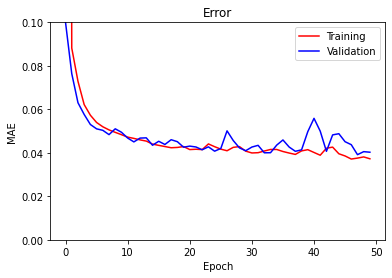

In [ ]:
from matplotlib import pyplot as plt 

plt.subplot(111)
plt.title("Error") 
plt.xlabel("Epoch") 
plt.ylabel("MAE") 
plt.ylim([0, 0.1])
plt.plot(train_err_graph, 'r') 
plt.plot(validation_err_graph, 'b') 
plt.legend(['Training','Validation'])
plt.show()


In [ ]:
UNET.load_weights('/content/gdrive/My Drive/lowestvalid.h5')

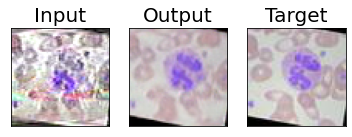

0
32/32 [==============================] - 0s 899us/step
 [Testing Batch 0/37]  [T loss: 0.041916] 
1
32/32 [==============================] - 0s 730us/step
 [Testing Batch 1/37]  [T loss: 0.040879] 
2
32/32 [==============================] - 0s 717us/step
 [Testing Batch 2/37]  [T loss: 0.041299] 
3
32/32 [==============================] - 0s 717us/step
 [Testing Batch 3/37]  [T loss: 0.042033] 
4
32/32 [==============================] - 0s 712us/step
 [Testing Batch 4/37]  [T loss: 0.041377] 


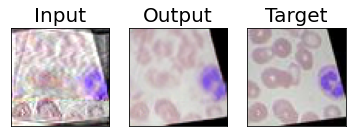

5
32/32 [==============================] - 0s 817us/step
 [Testing Batch 5/37]  [T loss: 0.040985] 
6
32/32 [==============================] - 0s 720us/step
 [Testing Batch 6/37]  [T loss: 0.040893] 
7
32/32 [==============================] - 0s 715us/step
 [Testing Batch 7/37]  [T loss: 0.040899] 
8
32/32 [==============================] - 0s 704us/step
 [Testing Batch 8/37]  [T loss: 0.040719] 
9
32/32 [==============================] - 0s 722us/step
 [Testing Batch 9/37]  [T loss: 0.041008] 


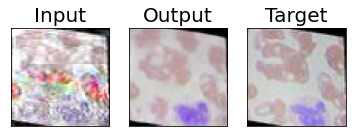

10
32/32 [==============================] - 0s 744us/step
 [Testing Batch 10/37]  [T loss: 0.040918] 
11
32/32 [==============================] - 0s 716us/step
 [Testing Batch 11/37]  [T loss: 0.040905] 
12
32/32 [==============================] - 0s 720us/step
 [Testing Batch 12/37]  [T loss: 0.040998] 
13
32/32 [==============================] - 0s 718us/step
 [Testing Batch 13/37]  [T loss: 0.040964] 
14
32/32 [==============================] - 0s 732us/step
 [Testing Batch 14/37]  [T loss: 0.040911] 


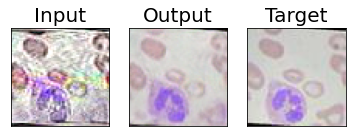

15
32/32 [==============================] - 0s 794us/step
 [Testing Batch 15/37]  [T loss: 0.040865] 
16
32/32 [==============================] - 0s 726us/step
 [Testing Batch 16/37]  [T loss: 0.040723] 
17
32/32 [==============================] - 0s 719us/step
 [Testing Batch 17/37]  [T loss: 0.040697] 
18
32/32 [==============================] - 0s 716us/step
 [Testing Batch 18/37]  [T loss: 0.040646] 
19
32/32 [==============================] - 0s 728us/step
 [Testing Batch 19/37]  [T loss: 0.040582] 


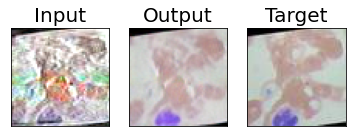

20
32/32 [==============================] - 0s 783us/step
 [Testing Batch 20/37]  [T loss: 0.040558] 
21
32/32 [==============================] - 0s 721us/step
 [Testing Batch 21/37]  [T loss: 0.040679] 
22
32/32 [==============================] - 0s 721us/step
 [Testing Batch 22/37]  [T loss: 0.040736] 
23
32/32 [==============================] - 0s 733us/step
 [Testing Batch 23/37]  [T loss: 0.040716] 
24
32/32 [==============================] - 0s 713us/step
 [Testing Batch 24/37]  [T loss: 0.040702] 


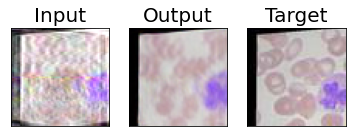

25
32/32 [==============================] - 0s 841us/step
 [Testing Batch 25/37]  [T loss: 0.040724] 
26
32/32 [==============================] - 0s 732us/step
 [Testing Batch 26/37]  [T loss: 0.040637] 
27
32/32 [==============================] - 0s 734us/step
 [Testing Batch 27/37]  [T loss: 0.040571] 
28
32/32 [==============================] - 0s 715us/step
 [Testing Batch 28/37]  [T loss: 0.040545] 
29
32/32 [==============================] - 0s 726us/step
 [Testing Batch 29/37]  [T loss: 0.040565] 


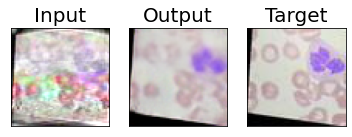

30
32/32 [==============================] - 0s 818us/step
 [Testing Batch 30/37]  [T loss: 0.040596] 
31
32/32 [==============================] - 0s 720us/step
 [Testing Batch 31/37]  [T loss: 0.040555] 
32
32/32 [==============================] - 0s 728us/step
 [Testing Batch 32/37]  [T loss: 0.040562] 
33
32/32 [==============================] - 0s 742us/step
 [Testing Batch 33/37]  [T loss: 0.040594] 
34
32/32 [==============================] - 0s 739us/step
 [Testing Batch 34/37]  [T loss: 0.040601] 


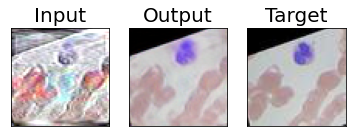

35
32/32 [==============================] - 0s 769us/step
 [Testing Batch 35/37]  [T loss: 0.040576] 
36
32/32 [==============================] - 0s 741us/step
 [Testing Batch 36/37]  [T loss: 0.040555] 


In [ ]:

batch_size = 32

n_batches = dataset_loader.get_num_batches(batch_size)
n_batches2 = dataset_loader.get_num_batches(batch_size, is_training=False, is_testing=False) #validation
n_batches3 = dataset_loader.get_num_batches(batch_size, is_training=False, is_testing=True) #test

valid = np.ones((batch_size,))
fake = np.zeros((batch_size,))


t_avg_loss = []

#validation error
for batch_i, [imgs_A, imgs_B] in enumerate(dataset_loader.load_batch(batch_size, is_training=False, is_testing=True, borrow_magnitude= mag_borrow)):
  fake_A = UNET.predict(imgs_B) 
  if batch_i%5 == 0:
    showColoredIms(imgs_B, fake_A, imgs_A) 
  print(batch_i)
  t_loss = UNET_MODEL.evaluate(imgs_B,imgs_A)
  t_avg_loss.append(t_loss[0])
  if batch_i%1 == 0:          
      print (" [Testing Batch %d/%d]  [T loss: %f] " % (
            batch_i, n_batches3, np.mean(t_avg_loss)))  
      



Test loss: 0.040555